# Pattern recognition with SVD

### Nicola Lombardi, Computational Linear Algebra for Large Scale Problems, Politecnico di Torino

## Abstract

The aim of this report, is to illustrate how SVD can be used to do pattern recognition. In particular, we will show that with the use of SVD it is possible to recognize different hand written digits, in a supervised learning settings.

## Loading and Preparing the Data

MNIST is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels). Each image is represent with a matrix of integer between 0 and 255, where 0 represents black and 255 white. Data will be normalized and than partitioned in a training set, a validation set and a test set.

In [1]:
# imports and seeding
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
from IPython.display import display

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

rs = 296278
np.random.seed(rs)
# pd.options.display.max_columns = 7

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml(
    "mnist_784", version = 1, return_X_y = True, as_frame = False)

In [3]:
# normalization of data, from [0, 255] to [0, 1]
X = X / 255.0

In [4]:
# Split data into train partition and test partition
size_test = 0.2
size_validation = 0.2

X_train, X_res, y_train, y_res = train_test_split(X, y, random_state = rs, 
                                                  test_size = size_test + size_validation)
X_val, X_test, y_val, y_test = train_test_split(X_res, y_res, random_state = rs, 
                                                test_size = size_test/(size_test+size_validation))

In [5]:
# transform data into pandas Series and DataFrames
train_y = pd.Series(y_train).astype('int').astype('category')
train_X = pd.DataFrame(X_train)
test_y = pd.Series(y_test).astype('int').astype('category')
test_X = pd.DataFrame(X_test)
val_y = pd.Series(y_val).astype('int').astype('category')
val_X = pd.DataFrame(X_val)

l = train_X.shape[1]
cols = ['pixel_' + str(x) for x in range(l)]
train_X.columns = cols
test_X.columns = cols
val_X.columns = cols
train_y.name = 'digits'
test_y.name = 'digits'
val_y.name = 'digits'

In [6]:
digits_distribution = pd.concat([train_y.value_counts().to_frame().T, 
                                 test_y.value_counts().to_frame().T, 
                                 val_y.value_counts().to_frame().T])
digits_distribution.index = ["train_y", "test_y", "val_y"]
digits_distribution.columns = [f"digit {col}" for col in digits_distribution.columns]
digits_distribution.sort_index(axis = 1, inplace = True)
digits_distribution["dimension"] = digits_distribution.sum(axis = 1)
digits_distribution

,digit 0,digit 1,digit 2,digit 3,digit 4,digit 5,digit 6,digit 7,digit 8,digit 9,dimension
train_y,4162,4741,4278,4273,4062,3792,4140,4283,4138,4131,42000
test_y,1390,1542,1325,1386,1422,1253,1406,1526,1353,1397,14000
val_y,1351,1594,1387,1482,1340,1268,1330,1484,1334,1430,14000


Each digit compose ~10% of both the train and the test datasets.

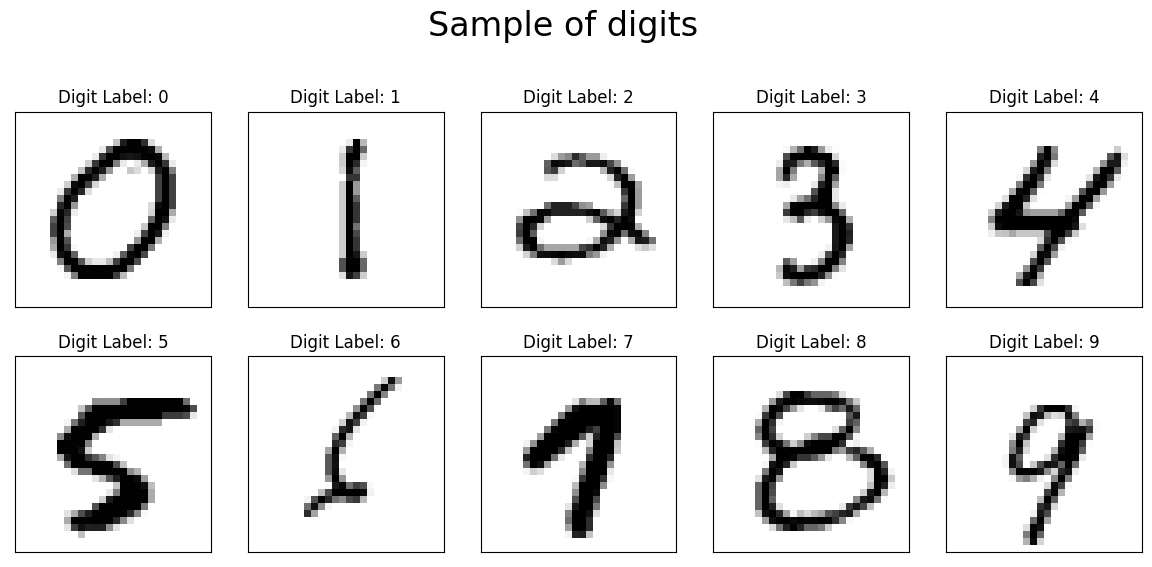

In [7]:
# show sample of digits
fig, axes = plt.subplots(2,5, 
                         figsize = (12, 6),
                         sharex = True, sharey = True)
fig.suptitle("Sample of digits \n", fontsize = 24)
fig.tight_layout(h_pad = 1.5)
for num, ax in enumerate(fig.get_axes()):
    i_row_num = min(train_y.index[train_y.values == num])
    # plot image on subplot
    image = np.reshape(train_X.loc[i_row_num,:].values, (28, 28))
    ax.imshow(image, cmap='gray_r')
    ax.set_title('Digit Label: {}'.format(num))
    ax.set_xticks([])
    ax.set_yticks([])

In this sample is visible that not all digits are decently drawn (see '6' and '7').

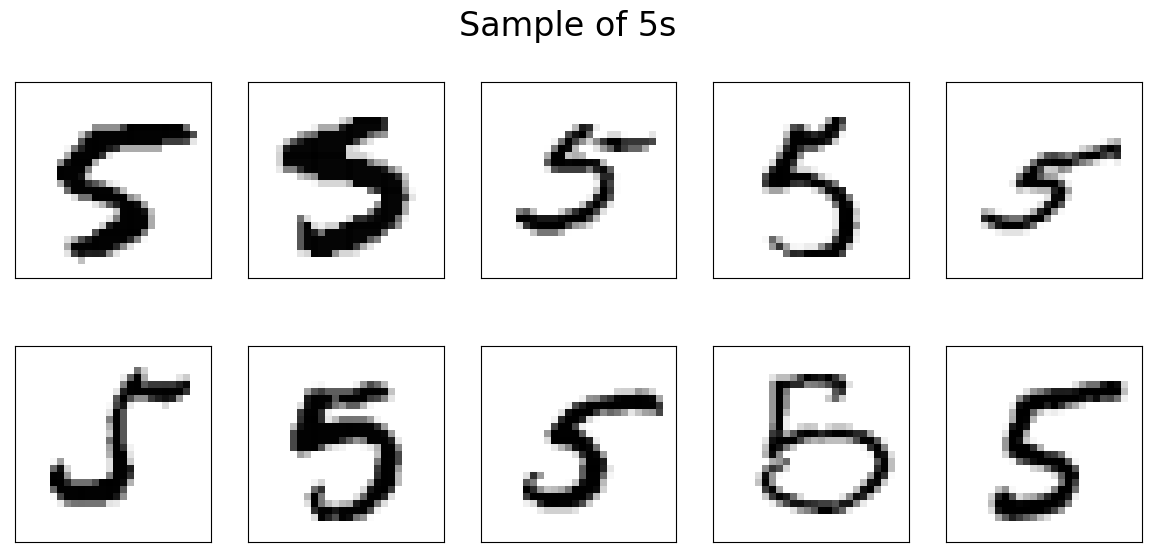

In [8]:
# show sample of {number}s
curr_num = 5

fig, axes = plt.subplots(2, 5, 
                         figsize = (12, 6),
                         sharex = True, sharey = True)
fig.suptitle(f"Sample of {curr_num}s", fontsize = 24)
fig.tight_layout(h_pad=1.5)
i_curr_num = train_y.index[train_y.values == curr_num][0:10]
for num, ax in enumerate(fig.get_axes()):
    i_row_num = i_curr_num[num]
    # plot image on subplot
    image = np.reshape(train_X.loc[i_row_num,:].values, (28, 28))
    ax.imshow(image, cmap = 'gray_r')
    ax.set_xticks([])
    ax.set_yticks([])

We may see that a great variety of '5's are present in the dataset, the same may be said for the other digits.

## Singular Values Decomposition

A singular value $\sigma$ af a matrix $A\in\mathbb{R}^{m\times n}$ is a non negative number such that there exist a couple of vectors $u\in\mathbb{R}^{m},v\in\mathbb{R}^{n}$ such that
$$Av=\sigma u \quad A^Tu=\sigma v$$
Also, $u$ is called left singular vector corresponding to $\sigma$, and  $v$ is called right singular vector corresponding to $\sigma$.

Singular Values Decomposition (SVD) is a powerful tool from linear algebra that, given a matrix $A$, rewrites it by decomposing it as a product of three matrices:
$$A = U\Sigma V^T$$
Where:
* $\Sigma\in\mathbb{R}^{m\times n}$ is an all 0s matrix but the entries with the same row and column, which contain the singular values of A in decreasing order;
* $U\in\mathbb{R}^{m\times m}$ contains as columns the vectors $u$ corresponding to the relative $\sigma$, normalized. The columns corresponding to non 0 singular values are orthonormal, and those corresponding to 0 singular values can be made so;
* $V\in\mathbb{R}^{n\times n}$ contains as columns the vectors $v$, corresponding to the relative $\sigma$, normalized. The columns corresponding to non 0 singular values are orthonormal, and those corresponding to 0 singular values can be made so;

In particular, for our applications, we will need a way to compute $U$ and $\Sigma$. 
Let now consider the matrix $A^TA$:
$$A^TA=V\Sigma^TU^TU\Sigma V^T = V\Sigma^TI_{m\times m}\Sigma V^T = V\Sigma^T\Sigma V^T $$
which is simmetric positive semidefinite. Moreover $A^TAv=\sigma^2v$ for $v\in columns(V)$.
Computing the eigenvalues and eigenvectors of $A^TA$ is then equivalent to compute the SVD of $A$, that because, knowing each $\sigma$ and corresponding $v$ allows us to compute the corrisponding $u=\frac{1}{\sigma}Av$. This allows us to evaluate the first columns of $U$, which we can complete to a basis of $\mathbb{R}^m$.

Let's now show an implementation of SVD. The evaluation of the eigenvalues and eigenvector of $A^TA$ will be done using a library for simplicity's sake, but it may be done with algorithms seen in class such as the QR-RQ method.

In [9]:
def my_svd(A):
    (m,n) = A.shape
    eigenval, eigenvec = np.linalg.eig(np.matmul(np.transpose(A), A))
    # sorting of singular values and v-s
    Vh = np.transpose(eigenvec)
    Vh = Vh[(-eigenval).argsort()]
    eigenval = eigenval[(-eigenval).argsort()]
    Sigma = np.zeros((m,n))
    for i in range(min(m,n)):
        Sigma[i,i] = np.sqrt(eigenval[i])
    # fill U with the meaningful columns
    U = []
    for i in range(min(m,n)):
        s = Sigma[i,i]
        if s != 0:
            curr = 1/s*A.dot(Vh[i,:].T)
            U.append(curr)
            
    # complete columns(U) to a basis
    l = len(U)
    j = 0
    while l != m:
        curr = np.zeros(m)
        curr[j] = 1
        for i in range(l):
            curr = curr - (np.dot(U[i], curr))*U[i]
        curr_norm = np.linalg.norm(curr)
        if curr_norm != 0:
            curr = curr / curr_norm
            l = l + 1
            U.append(curr)
        j = j + 1
    U = np.array(U).T
    return(U, Sigma, Vh)

Let's now compare our version of the SVD algorithm to the one given by the numpy library

In [10]:
A = np.random.rand(1000,600)
import time
start_time = time.time()
(my_U, my_S, my_Vh) = my_svd(A)
my_time = (time.time() - start_time)
start_time = time.time()
(np_U, np_S, np_Vh) = np.linalg.svd(A)
np_time = (time.time() - start_time)

Efficiency:

In [11]:
print(f"Time elapsed for our implementation: {my_time}")
print(f"Time elapsed for numpy's implementation: {np_time}")

Time elapsed for our implementation: 2.279132127761841
Time elapsed for numpy's implementation: 0.844423770904541


And accuracy:

In [12]:
# components may be flipped, 
# i.e numpy's v and u may corresponds to
# our -v and -u
case1 = max(abs(my_U[:,0]-np_U[:,0]))
case2 = max(abs(my_U[:,0]+np_U[:,0]))
print(f"Error of the first PC (1-norm): {min(case1, case2)}")

Error of the first PC (1-norm): 5.724587470723463e-16


We seems to have implemented an accurate version of the SVD algorithm. Unfortunately, this is not the case: increasing the size of the matrix, approximation errors build up. Moreover, our version is slow, and that is due to the fact that python is a compiled language and numpy is a library partially written in C. If we also implement the evaluation of eigenvalues and eigenvectors, the algorithm will be even slower. 

Those are the reasons why, in the following section, we will use the numpy algorithm to do the Singular Values Decomposition.

## SVDs and singular vectors

In order to model each digit, we will apply SVD to each subset of digits. This allows us to have models of each singular digits, that can be used in the following sections to classifies the data in the test set.

In [13]:
# sp_svd
U_svds = []
sigma_svds = []
Vh_svds = []
for i in range(10):
    U, s, Vh = np.linalg.svd(train_X.loc[train_y == i,:].T, full_matrices = False)
    U_svds.append(U)
    sigma_svds.append(s)
    Vh_svds.append(Vh)

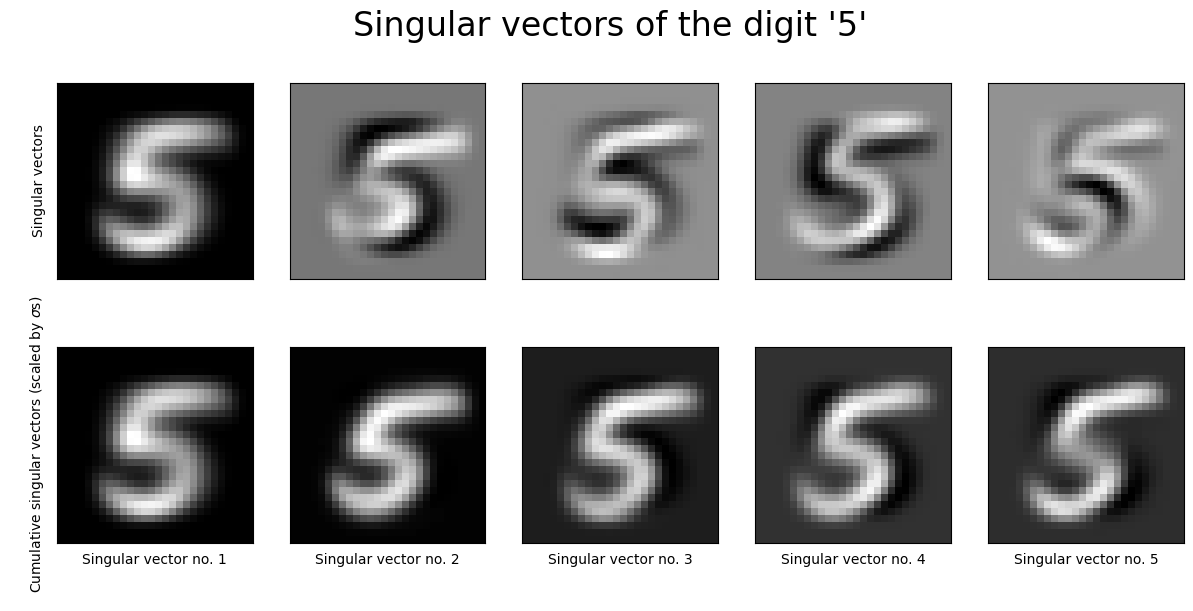

In [14]:
# plot of some singular vectors
target_number = 5
U = U_svds[target_number]

n_sv = 5

fig, axes = plt.subplots(2, n_sv, 
                         figsize = (12, 6),
                         sharex = True, sharey = True)
fig.suptitle(f"Singular vectors of the digit '{target_number}'", fontsize = 24)
fig.tight_layout(h_pad = 1.5) 
cum_sum = []

s = sigma_svds[target_number]
for num, ax in enumerate(fig.get_axes()):
    if num < n_sv:
        image = U[:, num].reshape(28,28)
        if num == 0:
            ax.set_ylabel("Singular vectors")
            cum_sum.append(image*s[num])
        else:
            cum_sum.append(cum_sum[num - 1] + image*s[num]) 
    else:
        if num == n_sv:
            ax.set_ylabel("Cumulative singular vectors (scaled by $\sigma$s)")
        image = cum_sum[num - n_sv]
        ax.set_xlabel(f"Singular vector no. {num-n_sv+1}")
    ax.imshow(image, cmap = 'gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
fig.text(0, 0, " ") #needed to show the z axis correctly
plt.show()

As shown above, each column of $U$ corresponds to a vector which resemble the corresponding digit.

The second row may be interpreted as: the more faded the area, the more that region may be different in different digits.

Finally, for all digits, let us visualize the Frobenius norm of the error, which is an indicator of how much information is being ignored of the original data, and can be obtained summing the ignored singular values.

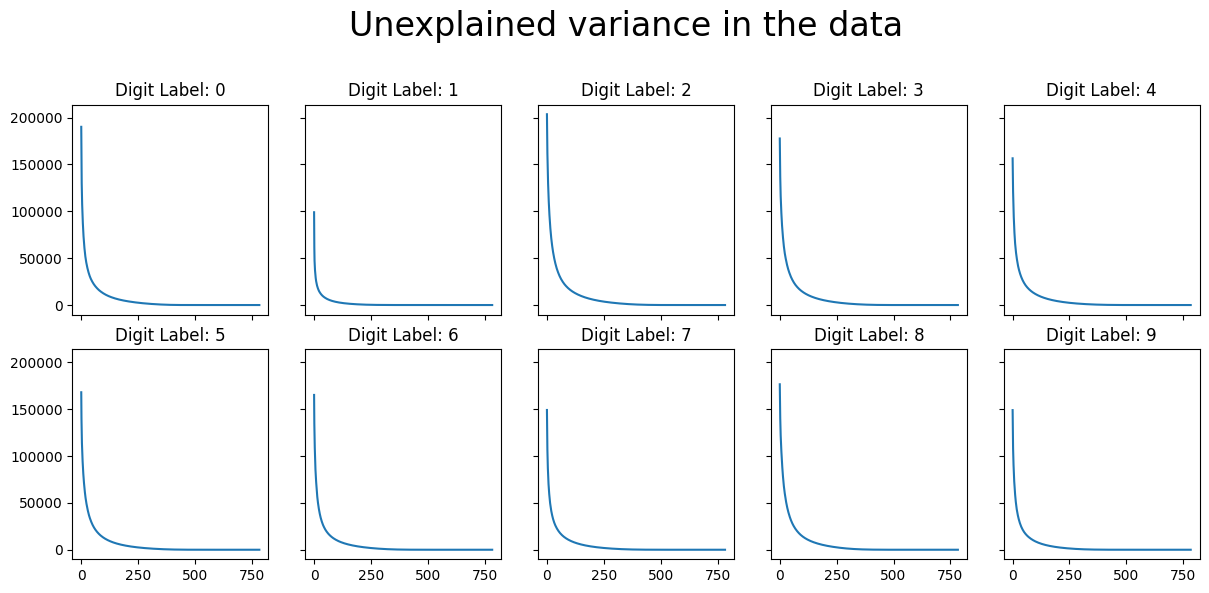

In [15]:
# unexplained variances
fig, axes = plt.subplots(2,5, 
                         figsize = (12, 6),
                         sharex = True, sharey = True)
fig.suptitle("Unexplained variance in the data\n", fontsize = 24)
fig.tight_layout(h_pad = 1.5)

sigma_2 = [] 
x = [i for i in range(28*28)]
for s in sigma_svds:
    sigma_2_curr = np.cumsum(s**2)
    sigma_2.append(sigma_2_curr[-1]-sigma_2_curr)

for num, ax in enumerate(fig.get_axes()):
    ax.plot(x,sigma_2[num])
    ax.set_title('Digit Label: {}'.format(num))
    #ax.set_xticks([])
    #ax.set_yscale("log")
    #ax.set_yticks([])

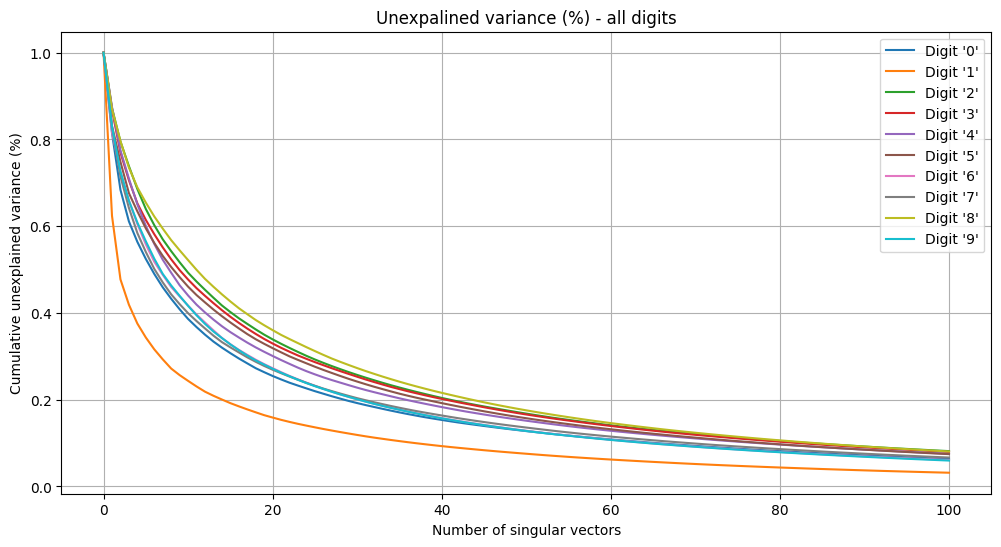

In [16]:
# Unexpalined variance (%) - all digits
plt.figure(figsize = (12, 6))
for i in range(10):
    curr_data = sigma_2[i]/sigma_2[i][0]
    curr_data = curr_data[0:101]
    plt.plot(curr_data, label = f"Digit '{i}'")
plt.legend()
plt.title('Unexpalined variance (%) - all digits')
plt.xlabel('Number of singular vectors')
plt.ylabel('Cumulative unexplained variance (%)')
plt.grid()
plt.show()

## Pattern recognition using SVD

Let's now describe what we are going to do to classify each digit.
Let's take, for example, a digit '5'. How can we recognize it is a '5' and not another digit? 

We may approximate it using the first k columns of the basis given by the singular vectors. Then, the better the approximation, the better the resemblance with that specific digit, so the more likely the currert digit belong to that category. In formula:
$$i^*=\arg\min(i\in[0,\dots,9].\ \| z-z_k^{(i)} \|_2)$$
Where $z$ is the digit we want to classify and:
$$ z_k = \sum\limits_{i=1}^k \langle z,u^{(i)}_k\rangle u^{(i)}_k$$

It may be proven that the minimization problem is equivalent to:

$$i^*=\arg\min\left(i\in[0,\dots,9].\ \| (I-U_k^{(i)}(U_k^{(i)})^T)z \|_2\right)=\arg\min\left(i\in[0,\dots,9].\ \frac{\| (I-U_k^{(i)}(U_k^{(i)})^T)z \|_2}{\| z\|_2}\right)$$

We provide an example of a decomposition of a digit '5', and plot the relative error of the approximation in 2-norm.

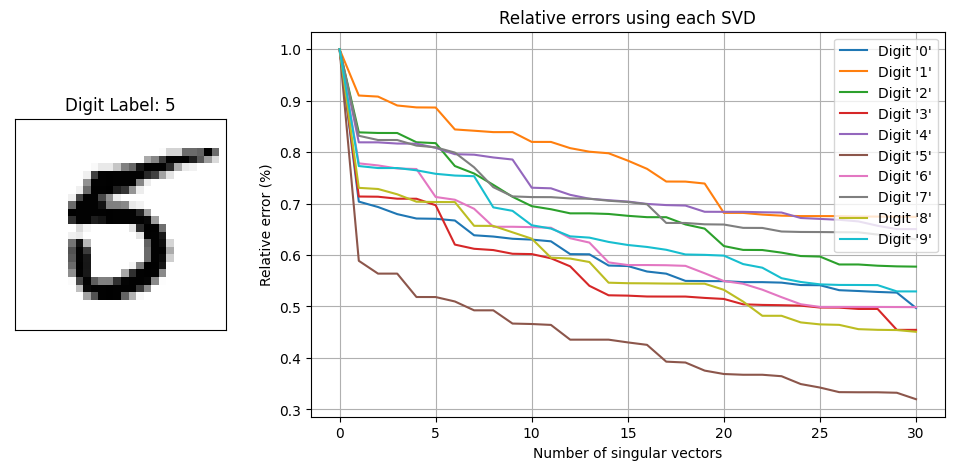

In [17]:
target_number = 5
U = U_svds[target_number]
k = 30
number = test_X[test_y == target_number].head(1).squeeze()
relative_errors = []

for U in U_svds:
    curr_errors = []
    curr_number = number
    original_norm = np.linalg.norm(curr_number)
    curr_errors.append(original_norm)
    for i in range(k):
        curr_number = curr_number - np.dot(curr_number, U[:, i])*U[:,i]
        curr_errors.append(np.linalg.norm(curr_number))
    relative_errors.append(curr_errors/original_norm)
#
f, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 5), gridspec_kw={'width_ratios': [1, 3]})
for i in range(10):
    curr_data = relative_errors[i]
    ax1.plot(curr_data, label = f"Digit '{i}'")
ax1.legend(loc = "upper right")
ax1.set_title('Relative errors using each SVD')
ax1.set_xlabel('Number of singular vectors')
ax1.set_ylabel('Relative error (%)')
ax1.grid()

image = np.reshape(number.values, (28, 28))
ax0.imshow(image, cmap = 'gray_r')
ax0.set_title('Digit Label: {}'.format(target_number))
ax0.set_xticks([])
ax0.set_yticks([])
print()

As we can see, with the basis given by the SVD of '5', the relative error is the smallest. And that holds true even when considering only a few singular vectors.

Below, we show how this particular '5' is reconstructed by some of the SVDs.

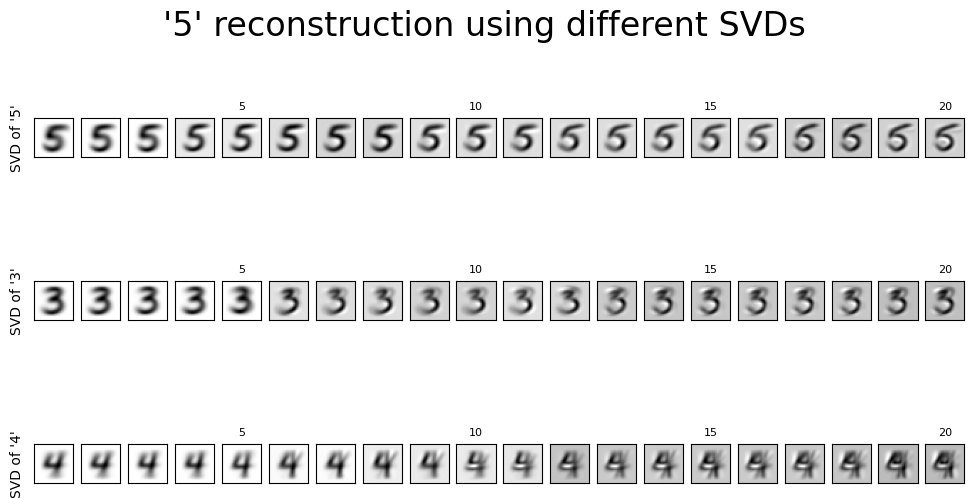

In [18]:
n_pcs = 20
svds = [5, 3, 4]

n_svds = len(svds)

fig, axes = plt.subplots(n_svds, n_pcs, 
                         figsize = (12, 6),
                         sharex = True, sharey = True)
fig.suptitle(f"'5' reconstruction using different SVDs", fontsize = 24)
#fig.tight_layout(h_pad=1.5)
for i_svd, curr_svd in enumerate(svds):
    curr_comp = np.zeros(784)
    U = U_svds[curr_svd]
    for i in range(n_pcs):
        curr_comp = curr_comp + np.dot(number, U[:, i])*U[:,i]
        image = np.reshape(curr_comp, (28, 28))
        axes[i_svd, i].imshow(image, cmap = 'gray_r')
        axes[i_svd, i].set_xticks([])
        axes[i_svd, i].set_yticks([])
        if i%5 == 4:
            axes[i_svd, i].set_title(f"{i+1}", fontsize=8)
    axes[i_svd,0].set_ylabel(f"SVD of '{curr_svd}'")

Let's now use this observations to find a value of k that allows for accuracy while at the same time being cheap to compute.

## Optimal number of singular components and accuracy

We now use the validation set to select the best possible number of singular vectors to be used to classify the digits.

In [19]:
k_max = 50
l_val = len(val_y)
errors = np.zeros((len(val_y), 10, k_max))
norm_digits = [np.linalg.norm(val_X.loc[i_digit]) for i_digit in range(l_val)]
for i in range(10):
    curr_approx_mat = np.identity(len(s))
    curr_U = U_svds[i]
    for k in range(k_max):
        # using orthonormality
        curr_u = curr_U[:,k]
        curr_approx_mat -= np.outer(curr_u,curr_u)
        curr_norms = np.linalg.norm(curr_approx_mat.dot(val_X.values.T), axis = 0)
        errors[:, i, k] = np.divide(curr_norms, norm_digits)

In [20]:
# row index: real label, column index: prediction
confusion_matrices = np.zeros((10,10,k_max), dtype = int) 
for k in range(k_max):
    for digit in range(l_val):
        curr_prediction = np.argmin(errors[digit, :, k])
        confusion_matrices[val_y[digit], curr_prediction, k] += 1

In [21]:
# calculate accuracy(%) for each kind of digit and k
accuracy = np.zeros((10,k_max))
for i in range(10):
    for k in range(k_max):
        accuracy[i,k] = confusion_matrices[i,i,k]/np.sum(confusion_matrices[i,:,k])

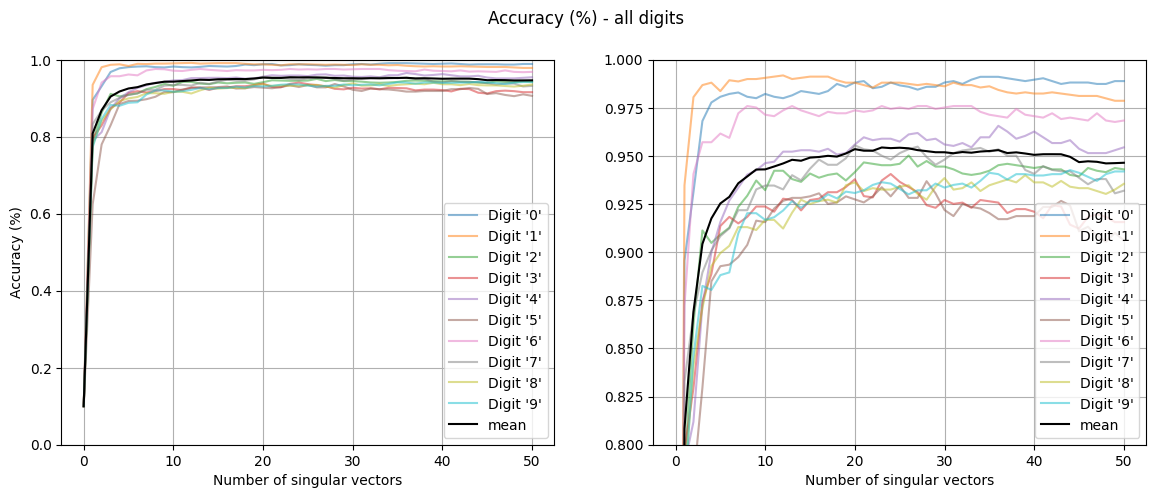

In [22]:
(fig, axes) = plt.subplots(1, 2, figsize = (14, 5))
ylim = []
ylim.append([0, 1])
ylim.append([0.8, 1])
fig.suptitle('Accuracy (%) - all digits')
for i_ax, ax in enumerate(fig.get_axes()):
    for i in range(10):
        ax.plot(np.insert(accuracy[i,:],0,0.1), label = f"Digit '{i}'", alpha=0.5)
    ax.plot(np.insert(np.mean(accuracy, axis = 0),0,0.1), label = "mean", color = "black")
    ax.legend(loc="lower right")
    ax.set_xlabel('Number of singular vectors')
    if i_ax == 0:
        ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(ylim[i_ax])
    ax.grid()

The most reasonable k seems to be 20, which gives us the biggest value of mean accuracy. Now let's see the result on the test set.

In [23]:
k = 20
l_test = len(test_y)
test_errors = np.zeros((len(test_y), 10))
norm_digits = [np.linalg.norm(test_X.loc[i_digit]) for i_digit in range(l_test)]
for i in range(10):
    curr_approx_mat = np.identity(len(s))
    curr_U = U_svds[i]
    for k in range(k):
        # using orthonormality
        curr_u = curr_U[:,k]
        curr_approx_mat -= np.outer(curr_u,curr_u)
    curr_norms = np.linalg.norm(curr_approx_mat.dot(test_X.values.T), axis = 0)
    test_errors[:, i] = np.divide(curr_norms, norm_digits)
# row index: real label, column index: prediction
confusion_mat_test = np.zeros((10,10),dtype=int) 
for digit in range(l_test):
    curr_prediction = np.argmin(test_errors[digit, :])
    confusion_mat_test[test_y[digit], curr_prediction] += 1

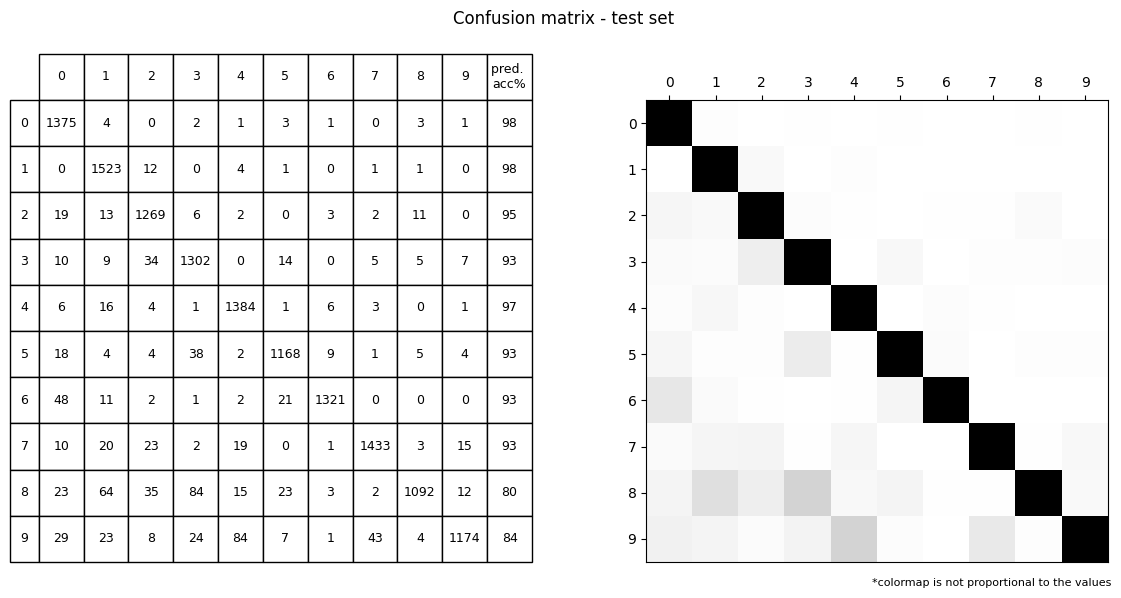

In [24]:
df_confusion_mat_test = pd.DataFrame(confusion_mat_test)
df_confusion_mat_test["correct prediction (%)"] = [df_confusion_mat_test.values[i,i]/np.sum(confusion_mat_test[i]) for i in range(10)]
df_confusion_mat_test["correct prediction (%)"] = np.floor(df_confusion_mat_test["correct prediction (%)"]*100)
(fig, (ax0,ax1)) = plt.subplots(1, 2, figsize = (14, 6))
fig.patch.set_visible(False)
ax0.axis('off')
ax0.axis('tight')
ax0.table(cellText = df_confusion_mat_test.values.astype(int), cellLoc='center', bbox=[0,0,1,1.1],
         rowLabels=[f"  {i}  " for i in range(10)], colLabels = ["pred. \nacc%" if i==10 else i for i in range(11)])
print_mat = df_confusion_mat_test.drop(columns = ["correct prediction (%)"]).applymap(lambda x: min([500,x]))
ax1.imshow(print_mat, cmap = 'gray_r')
ax1.set_xticks([i for i in range(10)])
ax1.xaxis.tick_top()
ax1.set_yticks([i for i in range(10)])
fig.text(0.72,0.07, "*colormap is not proportional to the values", fontsize = 8)
fig.suptitle("Confusion matrix - test set", y=1.03)
print()

## Conclusions

SVD works well for identifying some digits, not so for others. This may be caused by these digits be written by multiple people. Results may be better if more consistant data is provided. Similar digits ('3' and '8'; '4' and '9') are the most confused, as expected.

The same method can be used to recognize letters, faces, or other patterns. In particular, the recognition of letters in texts may be improved by grouping letters togeter in words and look for the most probable alternatives in online dictionaries.

Finally, this method can be modified to be even better: instead of keeping only a value of k, we may use a linear combination of them, then classify each digit according to this weighted average.

SVD is a powerful tool of linear algebra, and it's applications comprehend pattern recognition, as shown in this report.